Aquest Notebook analitza les dades del covid-19 a Catalunya, a partir de dades oficials penjades per la Generalitat de Catalunya a l'espai
de <a href=http://governobert.gencat.cat/ca/dades_obertes/>dades obertes</a>.
Les dades que s'utilizen en aquest análisi són a partir del 01/03/2020.

In [1]:
import json
import requests
import logging

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from datetime import datetime, timedelta

In [2]:
start_date = "2020-03-01"

covid_positive = 1
covid_negative = 0

In [3]:
def get_data_from_api(url, query):
    print(f"Request data to {url}")
    response = requests.get(url, params=query)
    
    data = dict()
    if response.status_code == requests.codes.OK:
        data = json.loads(response.text)
    else:
        print(f"Error to download data. Status code {response.status_code}.")
        
    return pd.DataFrame(data)

def generate_dates_range(start_date, end_date=None):
    start_date_dt = datetime.strptime(start_date, "%Y-%m-%d").date()
    end_date_dt = datetime.now().date() if not end_date else datetime.strptime(end_date, "%Y-%m-%d").date()
    delta = (end_date_dt - start_date_dt)
    
    return [end_date_dt - timedelta(days=x) for x in range(delta.days + 1)]

def get_data_from_api_filter_by_dates(url, start_date, end_date=None):
    dates_range = generate_dates_range(start_date, end_date)
    df = pd.DataFrame()
    for d in dates_range:
        print(f"Downloading data from date {d}...")
        
        query = {"$where": f"data='{d}'"}
        tmp_df = get_data_from_api(url, query)
        df = df.append(tmp_df, ignore_index=True)
    print("Done!")
    
    return df

### Source 1: Incidence of COVID-19

Dades diàries de la incidència de la COVID-19 a Catalunya elaborades per l’IDESCAT a partir de dades del Departament de Salut. La sèrie s'inicia el 24 de febrer de 2020 i s'actualitza cada dia.
Es proporcionen les xifres diàries de nous casos confirmats, defuncions i altes hospitalàries, així com els totals acumulats.

https://analisi.transparenciacatalunya.cat/Salut/Incid-ncia-de-la-COVID-19-a-Catalunya/623z-r97q

In [15]:
impact_df = get_data_from_api("https://analisi.transparenciacatalunya.cat/resource/623z-r97q.json", {})
impact_df.head()

Request data to https://analisi.transparenciacatalunya.cat/resource/623z-r97q.json


,data,nous_casos_diaris_confirmats,defuncions_di_ries,altes_hospital_ries_di_ries,total_casos_confirmats,total_defuncions,total_altes_hospital_ries
0,2020-04-15T00:00:00.000,2870,99,646,39375,3855,17297
1,2020-04-14T00:00:00.000,1308,90,684,36505,3756,16651
2,2020-04-13T00:00:00.000,471,128,365,35197,3666,15967
3,2020-04-12T00:00:00.000,699,96,627,34726,3538,15602
4,2020-04-11T00:00:00.000,1043,111,677,34027,3442,14975


#### Data cleaning

In [16]:
impact_df.dropna(inplace=True)

impact_df.loc[:, "data"] = pd.to_datetime(impact_df.data)
impact_df = impact_df[impact_df.data >= start_date]

impact_df.loc[:, "nous_casos_diaris_confirmats"] = impact_df.nous_casos_diaris_confirmats.astype(np.int)
impact_df.loc[:, "defuncions_di_ries"] = impact_df.defuncions_di_ries.astype(np.int)
impact_df.loc[:, "altes_hospital_ries_di_ries"] = impact_df.altes_hospital_ries_di_ries.astype(np.int)
impact_df.loc[:, "total_casos_confirmats"] = impact_df.total_casos_confirmats.astype(np.int)
impact_df.loc[:, "total_defuncions"] = impact_df.total_defuncions.astype(np.int)
impact_df.loc[:, "total_altes_hospital_ries"] = impact_df.total_altes_hospital_ries.astype(np.int)

impact_df.sort_values(by="data", ascending=False, inplace=True)
impact_df.set_index("data", inplace=True)

#### Data analysis

In [17]:
new_cases_color = "#6699ff"
discharge_color = "#00cc66"
decease_color = "#ff6666"

colors = [new_cases_color, discharge_color, decease_color]

def plot_time_cases(input_df, columns, title, legend, colors=colors):
    fig, ax = plt.subplots(figsize=(15, 7))
    impact_df[columns].plot(kind="line", ax=ax, title=title, color=colors)
    ax.legend(legend)
    ax.title.set_size(22)

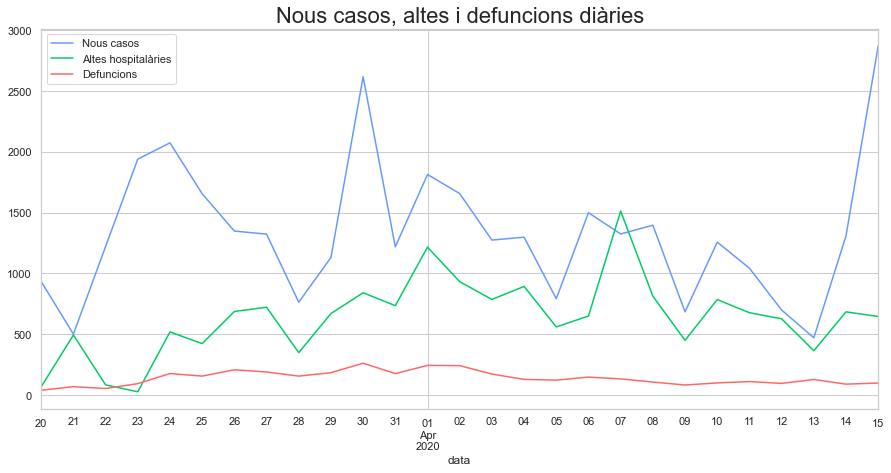

In [18]:
plot_time_cases(impact_df, columns=["nous_casos_diaris_confirmats", "altes_hospital_ries_di_ries", "defuncions_di_ries"], 
                title="Nous casos, altes i defuncions diàries", legend=["Nous casos", "Altes hospitalàries", "Defuncions"])

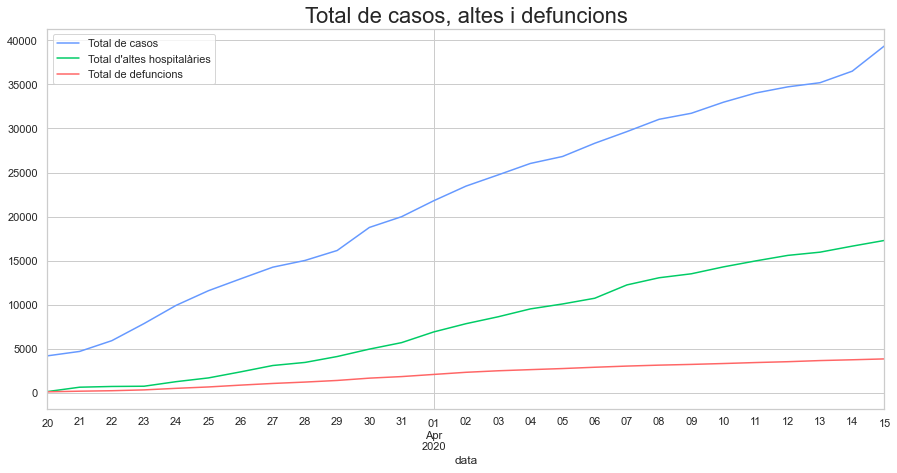

In [19]:
plot_time_cases(impact_df, columns=["total_casos_confirmats", "total_altes_hospital_ries", "total_defuncions"], 
                title="Total de casos, altes i defuncions", legend=["Total de casos", "Total d'altes hospitalàries", "Total de defuncions"])

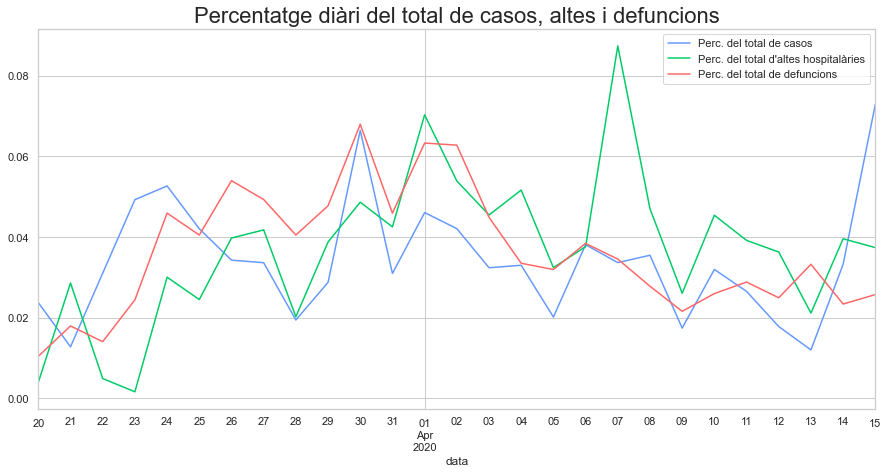

In [20]:
impact_df.loc[:, "total_casos_perc"] = impact_df["nous_casos_diaris_confirmats"] / impact_df["total_casos_confirmats"].max()
impact_df.loc[:, "total_altes_perc"] = impact_df["altes_hospital_ries_di_ries"] / impact_df["total_altes_hospital_ries"].max()
impact_df.loc[:, "total_defuncions_perc"] = impact_df["defuncions_di_ries"] / impact_df["total_defuncions"].max()

plot_time_cases(impact_df, columns=["total_casos_perc", "total_altes_perc", "total_defuncions_perc"], 
                title="Percentatge diàri del total de casos, altes i defuncions", 
                legend=["Perc. del total de casos", "Perc. del total d'altes hospitalàries", "Perc. del total de defuncions"])

### Source 2: Registry of COVID-19 test performed in Catalonia. Segregation by sex and age

Registre de test de COVID-19 realitzats a Catalunya segregat per sexe, rangs d'edat i regió sanitària.
Aquestes dades recullen els pacients que han estat diagnosticats a partir d'una prova de laboratori (PCR) i, alhora, s'ha pogut identificar la seva zona de residència.

La informació s'actualitza a dades obertes cada 3 hores.

Aquest dataset té dades des del 2020-02-02, però fins al Març, hi falten dies, per això, per realitzar aquest análisi, comença
a partir del dia 2020-03-01**

https://analisi.transparenciacatalunya.cat/ca/Salut/Registre-de-test-de-COVID-19-realitzats-a-Cataluny/qwj8-xpvk

In [23]:
gender_ages_df = get_data_from_api_filter_by_dates("https://analisi.transparenciacatalunya.cat/resource/qwj8-xpvk.json", start_date)
gender_ages_df.head()

Request data to https://analisi.transparenciacatalunya.cat/resource/qwj8-xpvk.json
Request data to https://analisi.transparenciacatalunya.cat/resource/qwj8-xpvk.json
Request data to https://analisi.transparenciacatalunya.cat/resource/qwj8-xpvk.json
Request data to https://analisi.transparenciacatalunya.cat/resource/qwj8-xpvk.json
Request data to https://analisi.transparenciacatalunya.cat/resource/qwj8-xpvk.json
Request data to https://analisi.transparenciacatalunya.cat/resource/qwj8-xpvk.json
Request data to https://analisi.transparenciacatalunya.cat/resource/qwj8-xpvk.json
Request data to https://analisi.transparenciacatalunya.cat/resource/qwj8-xpvk.json
Request data to https://analisi.transparenciacatalunya.cat/resource/qwj8-xpvk.json
Request data to https://analisi.transparenciacatalunya.cat/resource/qwj8-xpvk.json
Request data to https://analisi.transparenciacatalunya.cat/resource/qwj8-xpvk.json
Request data to https://analisi.transparenciacatalunya.cat/resource/qwj8-xpvk.json
Requ

""


#### Data cleaning

In [ ]:
gender_ages_df.loc[:, "data"] = pd.to_datetime(gender_ages_df.data)
gender_ages_df.loc[:, "numcasos"] = gender_ages_df.numcasos.astype(np.int)
gender_ages_df.loc[:, "resultatcovidcodi"] = gender_ages_df.resultatcovidcodi.astype(np.int)

# Only use positive and negative tests results
cond = gender_ages_df.resultatcovidcodi.isin([covid_negative, covid_positive])
gender_ages_df[:] = gender_ages_df[cond]

gender_ages_df.sort_values(by="data", ascending=False, inplace=True)

#### Data analysis

In [31]:
def plot_gruped(input_df, grouped_columns, sum_column, title, colors=[discharge_color, decease_color], stacked=True, rot=45):
    fig, ax = plt.subplots(figsize=(15, 7))

    grouped_df = input_df.groupby(grouped_columns)[sum_column].sum()
    grouped_df.unstack().plot(kind="bar", stacked=stacked, ax=ax, rot=rot, title=title, color=colors)

    ax.title.set_size(22)

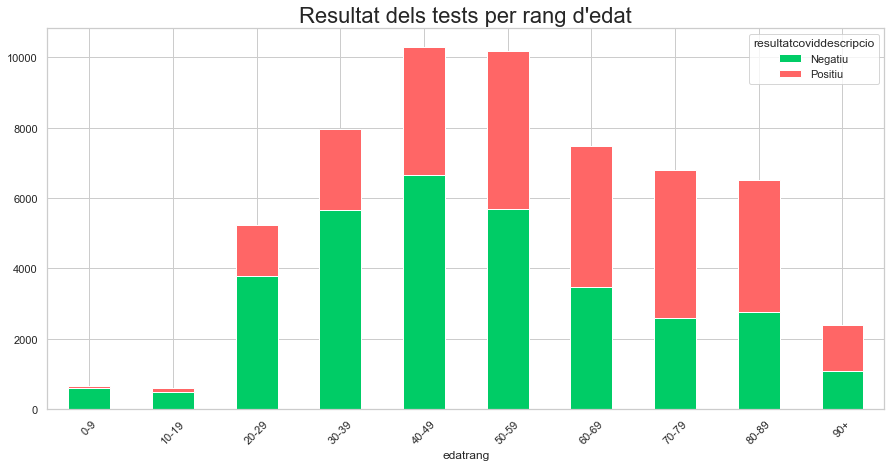

In [315]:
plot_gruped(gender_ages_df, ["edatrang", "resultatcoviddescripcio"], "numcasos", 
            f"Resultat dels tests per rang d'edat")

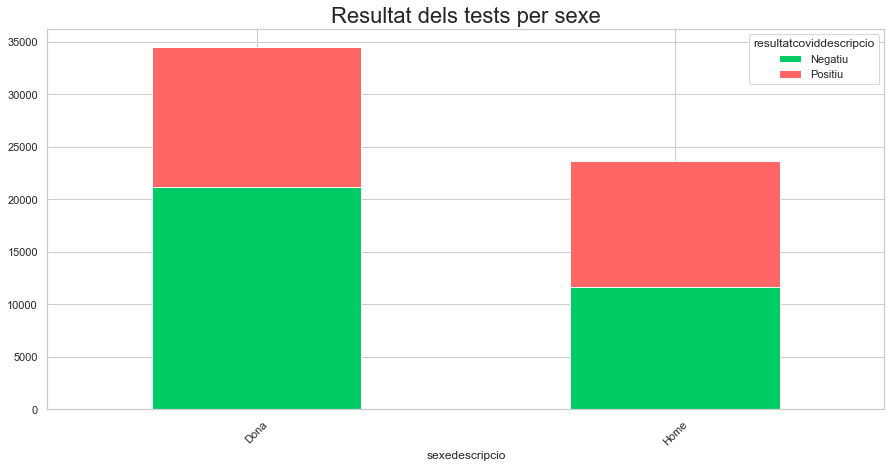

In [317]:
plot_gruped(gender_ages_df, ["sexedescripcio", "resultatcoviddescripcio"], "numcasos", f"Resultat dels tests per sexe")

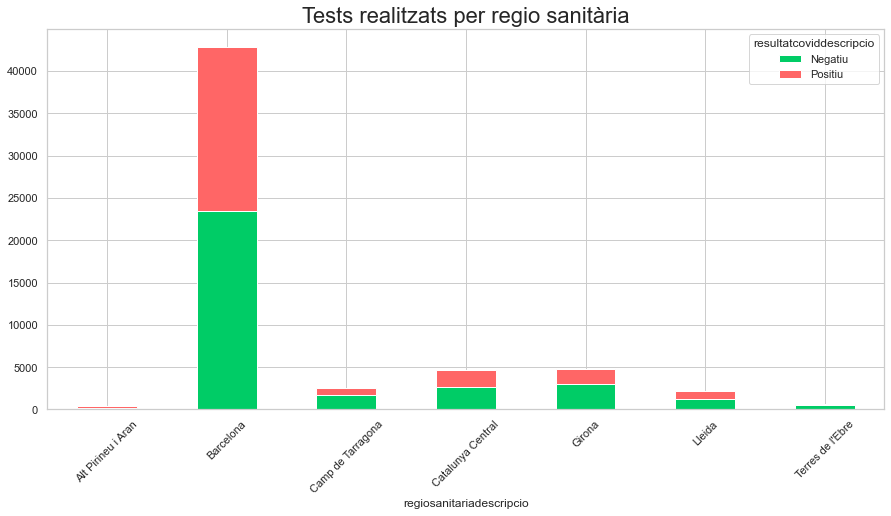

In [318]:
plot_gruped(gender_ages_df, ["regiosanitariadescripcio", "resultatcoviddescripcio"], "numcasos", f"Tests realitzats per regio sanitària")

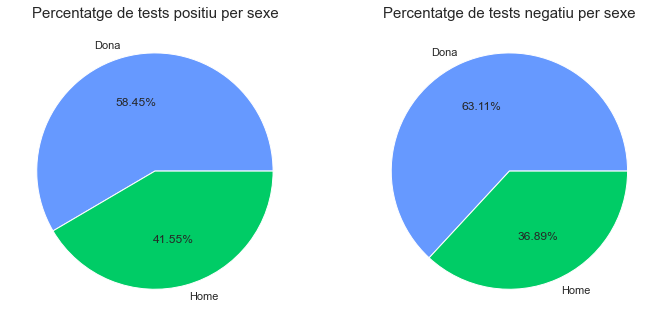

In [319]:
cond_pos = df.resultatcovidcodi == 1
cond_neg = df.resultatcovidcodi == 0

fig = plt.figure(figsize=(18,7))
list_conds = [cond_pos, cond_neg]
for i, cond in enumerate(list_conds, start=1):
    ax = fig.add_subplot(1, 3, i)
    
    grouped_df = df[cond].groupby(["sexedescripcio", "resultatcovidcodi"])["numcasos"].sum()
    grouped_df.unstack().plot(kind="pie", ax=ax, rot=45, colors=colors, subplots=True, autopct="%.2f%%", legend=False)

    label = df[cond]["resultatcoviddescripcio"].values[0]
    ax.set_ylabel("")
    ax.set_title(f"Percentatge de tests {label.lower()} per sexe")
    ax.title.set_size(15)

### Source 3: Registry of COVID-19 test performed in Catalonia. Segregation by sex and municipality

Registre del nombre de test de COVID-19 realitzats a Catalunya, segregats per municipi i sexe.
Aquestes dades recullen els pacients que han estat diagnosticats a partir d'una prova de laboratori (PCR) i, alhora, s'ha pogut identificar la seva zona de residència.

La informació s'actualitza a dades obertes cada 3 hores.

https://analisi.transparenciacatalunya.cat/Salut/Registre-de-test-de-COVID-19-realitzats-a-Cataluny/jj6z-iyrp

In [27]:
gender_loc_df = get_data_from_api_filter_by_dates("https://analisi.transparenciacatalunya.cat/resource/jj6z-iyrp.json", start_date)
gender_loc_df.head()

Request data to https://analisi.transparenciacatalunya.cat/resource/jj6z-iyrp.json
Request data to https://analisi.transparenciacatalunya.cat/resource/jj6z-iyrp.json
Request data to https://analisi.transparenciacatalunya.cat/resource/jj6z-iyrp.json
Request data to https://analisi.transparenciacatalunya.cat/resource/jj6z-iyrp.json
Request data to https://analisi.transparenciacatalunya.cat/resource/jj6z-iyrp.json
Request data to https://analisi.transparenciacatalunya.cat/resource/jj6z-iyrp.json
Request data to https://analisi.transparenciacatalunya.cat/resource/jj6z-iyrp.json
Request data to https://analisi.transparenciacatalunya.cat/resource/jj6z-iyrp.json
Request data to https://analisi.transparenciacatalunya.cat/resource/jj6z-iyrp.json
Request data to https://analisi.transparenciacatalunya.cat/resource/jj6z-iyrp.json
Request data to https://analisi.transparenciacatalunya.cat/resource/jj6z-iyrp.json
Request data to https://analisi.transparenciacatalunya.cat/resource/jj6z-iyrp.json
Requ

,data,municipidescripcio,sexecodi,sexedescripcio,resultatcovidcodi,resultatcoviddescripcio,numcasos,comarcacodi,comarcadescripcio,municipicodi
0,2020-04-15T00:00:00.000,(Altres municipis),0,Home,1,Positiu,84,NaN,NaN,NaN
1,2020-04-15T00:00:00.000,(Altres municipis),0,Home,0,Negatiu,264,NaN,NaN,NaN
2,2020-04-15T00:00:00.000,(Altres municipis),1,Dona,1,Positiu,158,NaN,NaN,NaN
3,2020-04-15T00:00:00.000,(Altres municipis),1,Dona,0,Negatiu,441,NaN,NaN,NaN
4,2020-04-14T00:00:00.000,(Altres municipis),0,Home,1,Positiu,215,NaN,NaN,NaN


#### Data cleaning

In [28]:
gender_loc_df.loc[:, "data"] = pd.to_datetime(gender_loc_df.data)
gender_loc_df.loc[:, "numcasos"] = gender_loc_df.numcasos.astype(np.int)
gender_loc_df.loc[:, "resultatcovidcodi"] = gender_loc_df.resultatcovidcodi.astype(np.int)

# Only use positive and negative tests results
cond = gender_loc_df.resultatcovidcodi.isin([covid_negative, covid_positive])
gender_loc_df[:] = gender_loc_df[cond]

gender_loc_df.sort_values(by="data", ascending=False, inplace=True)

#### Data analysis

In [32]:
gender_loc_df.comarcadescripcio.unique()

array([nan, 'Segarra', 'Baix Llobregat', 'Osona', 'Vallès Occidental',
       'Barcelonès', 'Gironès', 'Maresme', 'Ripollès', 'Garraf',
       "Pla de l'Estany", 'Vallès Oriental', 'Alt Empordà\xa0',
       'Conca de Barberà\xa0', 'Montsià\xa0', 'Segrià\xa0', 'Baix Camp',
       'Anoia', 'Alt Penedès', 'Selva', 'Garrotxa', 'Noguera',
       'Baix Empordà\xa0', 'Alt Camp', 'Urgell', 'Bages', 'Baix Penedès',
       'Pallars Sobirà\xa0', 'Moianès', "Ribera d'Ebre", 'Baix Ebre',
       'Tarragonès', 'Pallars Jussà\xa0', 'Berguedà\xa0', "Pla d'Urgell",
       'Alta Ribagorça', 'Cerdanya', 'Alt Urgell', 'Garrigues', 'Aran',
       'Terra Alta', 'Solsonès', 'Priorat'], dtype=object)

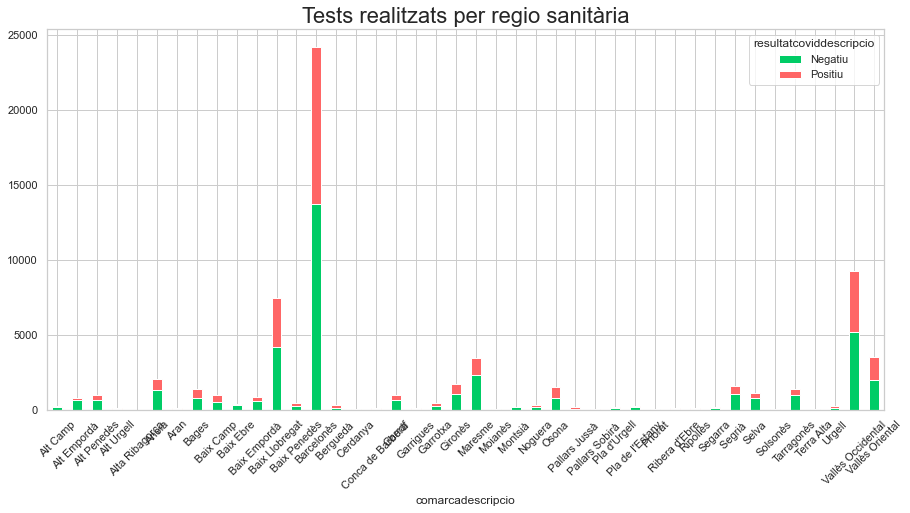

In [33]:
plot_gruped(gender_loc_df, ["comarcadescripcio", "resultatcoviddescripcio"], "numcasos", f"Tests realitzats per regio sanitària")

### Resources
<li><a href=https://analisi.transparenciacatalunya.cat/Salut/Incid-ncia-de-la-COVID-19-a-Catalunya/623z-r97q>https://analisi.transparenciacatalunya.cat/Salut/Incid-ncia-de-la-COVID-19-a-Catalunya/623z-r97q</a></li>
<li><a href=https://analisi.transparenciacatalunya.cat/ca/Salut/Registre-de-test-de-COVID-19-realitzats-a-Cataluny/qwj8-xpvk>https://analisi.transparenciacatalunya.cat/ca/Salut/Registre-de-test-de-COVID-19-realitzats-a-Cataluny/qwj8-xpvk</a></li>
<li><a href=https://analisi.transparenciacatalunya.cat/Salut/Registre-de-test-de-COVID-19-realitzats-a-Cataluny/jj6z-iyrp>https://analisi.transparenciacatalunya.cat/Salut/Registre-de-test-de-COVID-19-realitzats-a-Cataluny/jj6z-iyrp</a></li>